In [1]:
import numpy as onp
from scipy.integrate import solve_ivp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, sigmoid
from jax.config import config
from jax.lax import scan, fori_loop

from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import matplotlib.pyplot as plt

%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Architectures

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      subkey1,  subkey2 = random.split(rng_key)
      U1, b1 =  xavier_init(subkey1, layers[0], layers[1])
      U2, b2 =  xavier_init(subkey2, layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W))
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Data Sampler

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=True)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# Physics-informed DeepONet

In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    

        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))

        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps = 5000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        # Logger

        self.s1_error_log = []
        self.s2_error_log = []
        self.s3_error_log = []
        
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []

    # Define the opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        
        B1 = B[:100]
        B2 = B[100:200]
        B3 = B[200:]

        T1 = T[:100]
        T2 = T[100:200]
        T3 = T[200:]

        s1 = np.sum(B1 * T1)
        s2 = np.sum(B2 * T2)
        s3 = np.sum(B3 * T3)
        
        # rescale s2
        return s1, 1e-4 * s2, s3
            
    def residual_net(self, params, u, y):
        s1, s2, s3 = self.operator_net(params, u, y)

        def s1_fn(params, u, y):
          s1_fn, _, _ = self.operator_net(params, u, y)
          return s1_fn
        
        def s2_fn(params, u, y):
          _, s2_fn, _  = self.operator_net(params, u, y)
          return s2_fn
        
        def s3_fn(params, u, y):
          _, _, s3_fn  = self.operator_net(params, u, y)
          return s3_fn

        s1_y = grad(s1_fn, argnums= 2)(params, u, y)
        s2_y = grad(s2_fn, argnums= 2)(params, u, y)
        s3_y = grad(s3_fn, argnums= 2)(params, u, y)

        res_1 = s1_y + 0.04 * s1 - 1e4 * s2 * s3
        res_2 = s2_y - 0.04 * s1  + 1e4 * s2 * s3 + 3 * 1e7 * s2**2
        res_3 = s3_y - 3 * 1e7 * s2**2

        return res_1, res_2, res_3

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        s1 = outputs[:, 0:1]
        s2 = outputs[:, 1:2]
        s3 = outputs[:, 2:3]

        # Compute forward pass
        pred_s1, pred_s2, pred_s3 = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss_s1 = np.mean((s1.flatten() - pred_s1)**2)
        loss_s2 = np.mean((s2.flatten() - pred_s2)**2)
        loss_s3 = np.mean((s3.flatten() - pred_s3)**2)

        loss = loss_s1 + 1e6 * loss_s2 + loss_s3 
        return loss

    
    @partial(jit, static_argnums=(0,))
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        pred_res_1, pred_res_2, pred_res_3 = vmap(self.residual_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss_res_1 = np.mean((pred_res_1)**2)
        loss_res_2 = np.mean((pred_res_2)**2)
        loss_res_3 = np.mean((pred_res_3)**2)
        loss_res = loss_res_1 + loss_res_2 + loss_res_3
        return loss_res    

    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, ics_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =    loss_ics + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            ics_batch = next(ics_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, res_batch)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)        

                loss_value = self.loss(params, ics_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_res_value = self.loss_res(params, res_batch)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value, 
                                  'loss_res': loss_res_value})
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s1_pred, s2_pred, s3_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s1_pred, s2_pred, s3_pred

In [5]:
dt = 1.0

def system(s, t):
  s1 = s[0]
  s2 = s[1]
  s3 = s[2]
  ds1_dt = -0.04 * s1 + 1e4 * s2 * s3
  ds2_dt = 0.04 * s1  - 1e4 * s2 * s3  - 3 * 1e7 * s2**2
  ds3_dt = 3 * 1e7 * s2**2
  ds_dt = [ds1_dt, ds2_dt, ds3_dt]
  return ds_dt


def generate_one_training_data(key, m=1, P=1, Q = 100):

    key_u, key_r = random.split(key)
    key_u = random.split(key_u, 3)
    
    u_train_1 =  random.uniform(key_u[0], (m,1), minval=0.0, maxval=1.0)
    u_train_2 =  random.uniform(key_u[1], (m,1), minval=0.0, maxval=1.0)
    u_train_3 =  random.uniform(key_u[2], (m,1), minval=0.0, maxval=1.0)
    u_train = np.hstack([u_train_1, 1e-4 * u_train_2, u_train_3])

    y_train = np.zeros((P,))
    s_train = u_train

    u_r_train = np.tile(u_train, (Q, 1))
    y_r_train =  random.uniform(key_r, shape=(Q,), minval=0.0, maxval=dt)
    # y_r_train =  np.linspace(0, 1, Q)
    s_r_train = np.zeros((Q,1))

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

def generate_one_test_data(key, m=1, P=100):

    # Input sensor locations and measurements
    key = random.split(key, 3)
    
    u_1 =  random.uniform(key[0], (m,1), minval=0.0, maxval=1.0)
    u_2 =  random.uniform(key[1], (m,1), minval=0.0, maxval=1.0)
    u_3 =  random.uniform(key[2], (m,1), minval=0.0, maxval=1.0)
    u = np.hstack([u_1, 1e-4 * u_2, u_3])
    # Output sensor locations and measurements
    y = np.linspace(0, dt, P)
    s = odeint(system, u.flatten(), y)

    # Tile inputs
    u = np.tile(u, (P, 1))

    return u, y, s 

def generate_training_data(key, N, m, P, Q):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, m, P, Q))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train


def generate_test_data(key, N, m, P):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = np.float32(u.reshape(N * P,-1))
    y = np.float32(y.reshape(N * P,-1))
    s = np.float32(s.reshape(N * P,-1))
    return u, y, s


def compute_error(key, m, P):
    u_test, y_test, s_test = generate_test_data(key, 1, m, P)
    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error_s = np.linalg.norm(s_test - s_pred, 2) / np.linalg.norm(s_test, 2) 

    return error_s


In [6]:
# Training data
N_train = 50000 # number of ICs
m = 1 # number of input sensors
P_train = 1   # number of output sensors
Q_train = 1000   # number of output sensors
key_train = random.PRNGKey(0) # use different key for generating training data 
u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = generate_training_data(key_train, N_train, m, P_train, Q_train)

In [7]:
# Initialize model
branch_layers = [3, 100, 100, 100, 100, 100, 100, 100, 300]
trunk_layers =  [1, 100, 100, 100, 100, 100, 100, 100, 300]
model = PI_DeepONet(branch_layers, trunk_layers)

In [8]:
# Create data set
batch_size = 50000
ics_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
res_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [ ]:
# Train
model.train(ics_dataset, res_dataset, nIter=400000)

In [9]:
# Save the trained model
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('stiff_params.npy', flat_params)
# np.save('stiff_loss_res.npy', model.loss_res_log)
# np.save('stiff_loss_ics.npy', model.loss_ics_log)
# np.save('stiff_loss_test.npy', [model.s1_error_log, model.s2_error_log, model.s3_error_log])


# Restore the trained model
flat_params = np.load('stiff_params.npy')
_, unravel = ravel_pytree(model.get_params(model.opt_state))
params = unravel(flat_params)

# Plot

In [10]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                     'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 20,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 22,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

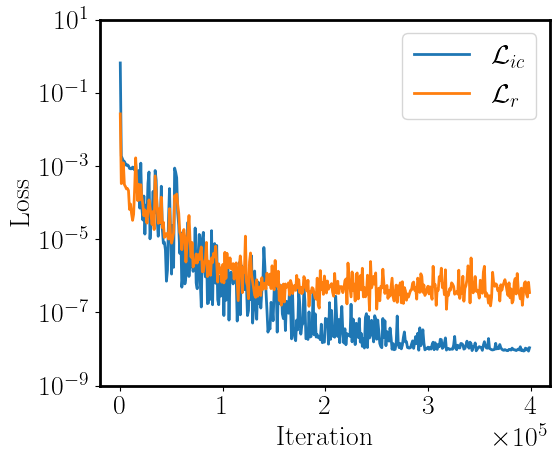

In [17]:
loss_ics = np.load('stiff_loss_ics.npy')[::10]
loss_res = np.load('stiff_loss_res.npy')[::10]

fig = plt.figure(figsize = (6,5))

iters = 1000 * np.arange(len(loss_ics))
# plt.plot(model.loss_log, lw=2)
plt.plot(iters, loss_ics, lw=2, label='$\mathcal{L}_{ic}$')
plt.plot(iters, loss_res, lw=2, label='$\mathcal{L}_{r}$')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim([1e-9, 1e1])
plt.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()

In [18]:
# dt = 1.0
P = 100

u0 = np.array([1.0, 0.0, 0.0])

u00 = u0.copy()

# Create the test data
u0_test = np.tile(u0, (P, 1))
y_test = np.linspace(0, dt, P).reshape(-1, 1)

s1_pred_0, s2_pred_0, s3_pred_0 = model.predict_s(params, u0_test, y_test)

s1_pred = s1_pred_0
s2_pred = s2_pred_0
s3_pred = s3_pred_0

N = 500
y = np.linspace(0, dt, 100).reshape(-1, 1)

for k in range(1, N):

  u0 = np.hstack([s1_pred[-1], s2_pred[-1], s3_pred[-1]])
  
  u = np.tile(u0, (P, 1))
  y = np.linspace(0, dt, 100).reshape(-1, 1)

  # params = model.get_params(model.opt_state)
  s1_pred_k, s2_pred_k, s3_pred_k = model.predict_s(params, u, y)

  s1_pred = np.hstack([s1_pred, s1_pred_k])
  s2_pred = np.hstack([s2_pred, s2_pred_k])
  s3_pred = np.hstack([s3_pred, s3_pred_k])



In [19]:
# Numerical solution
def system(s, t):
  s1 = s[0]
  s2 = s[1]
  s3 = s[2]
  ds1_dt = -0.04 * s1 + 1e4 * s2 * s3
  ds2_dt = 0.04 * s1  - 1e4 * s2 * s3  - 3 * 1e7 * s2**2
  ds3_dt = 3 * 1e7 * s2**2
  ds_dt = [ds1_dt, ds2_dt, ds3_dt]
  return ds_dt

y =  np.linspace(0, int(N * dt), int(100 * N))
s = odeint(system, u00, y)

error_s1 = np.linalg.norm(s1_pred - s[:,0])/ np.linalg.norm(s[:,0])
error_s2 = np.linalg.norm(s2_pred - s[:,1])/ np.linalg.norm(s[:,1])
error_s3 = np.linalg.norm(s3_pred - s[:,2])/ np.linalg.norm(s[:,2])

print('error s1: {:.3e}, error s2: {:.3e}, error s3: {:.3e}'.format(error_s1, error_s2, error_s3))

error s1: 5.699e-03, error s2: 6.413e-03, error s3: 4.828e-03


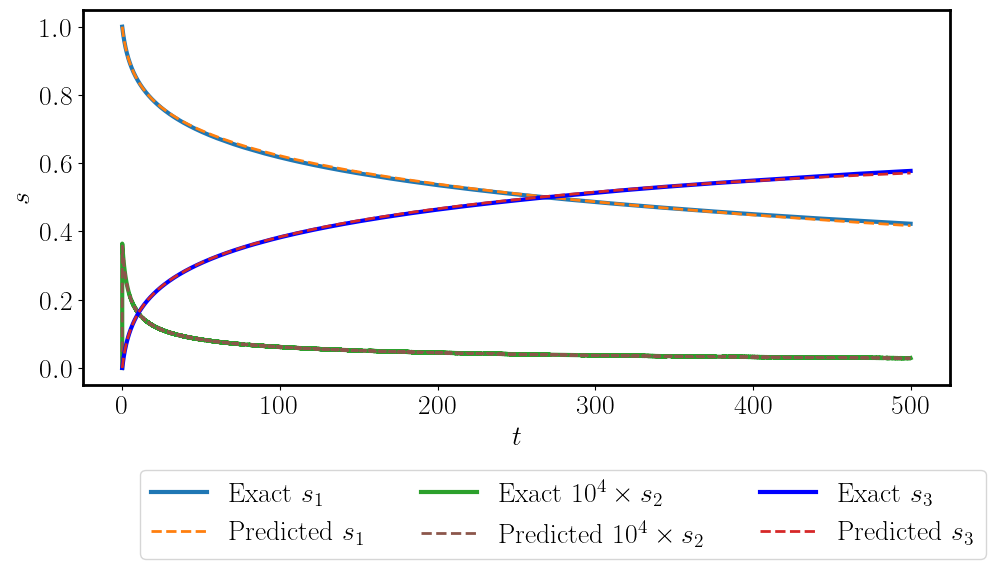

In [20]:
fig =plt.figure(figsize=(10, 5))
plt.plot(y, s[:,0], label='Exact $s_1$', color='C0')
plt.plot(y, s1_pred, '--', label='Predicted $s_1$', lw=2, color='C1')
plt.plot(y, 10000 * s[:,1], label='Exact $10^4 \\times s_2$', color='C2')
plt.plot(y, 10000 * s2_pred, '--', label='Predicted $10^4 \\times  s_2$', lw=2, color='C5')
plt.plot(y, s[:,2], label='Exact $s_3$', color='blue')
plt.plot(y, s3_pred, '--', label='Predicted $s_3$', lw=2, color='C3')
plt.ylabel('$s$')
plt.xlabel('$t$')
plt.tight_layout()
plt.legend(loc='lower left', ncol=3, bbox_to_anchor = (0.05, -0.5))
plt.show()